## Movie Recommendation System

### Datasets
This dataset consists of the following files:

`movies_metadata.csv`: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

`credits.csv`: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.

The above two files can be used for **Content-based filtering**   

`ratings_small.csv`: The subset of 100,000 ratings from 700 users on 9,000 movies. Can be used for **Collaborative Filtering**


In [1]:
import pandas as pd 
import os 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.io import output_notebook, show
import bokeh.plotting
import json 

In [2]:
movies_metadata= pd.read_csv('data/movies_metadata.csv', low_memory=False,encoding = 'iso-8859-1')
credit = pd.read_csv('data/credits.csv')

In [3]:
movies_metadata.shape

(45466, 24)

In [4]:
credit.shape

(45476, 3)

### 1. Exploratory Data Analysis

Explore the data using pandas and its plotting functions to understand some characteristics of the data. For instance   
- are there duplicate data and where?
- what are the datatypes of the columns?  
- how much information is missing and where?
- what are the useful columns?

#### 1.1 remove duplicate data

In [58]:
movies_metadata.duplicated().sum()

17

In [59]:
movies_metadata.drop_duplicates(inplace=True)
movies_metadata.shape

(45449, 24)

there are 17 rows/movie documents duplicate with others 

#### 1.2 correct datatypes of the columns

In [60]:
movies_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [61]:
credit.dtypes

cast    object
crew    object
id       int64
dtype: object

there are 24 columns in the movie dataset:  
- `id` are string type and should be correct as integer type
- `status`, `adult`, `video` are string types representing the boolean type, which can be transfer to binary value  
- `belongs_to_collection`,`genres`,`production_companies`,`production_countries`, are string types representing list of dict type, which need to be processed to convert to true list and separate to different columns. `belongs_to_collection` has too much missing data, not useful    
- `budget`,`popularity` are string type representing the float numbers type, and should be convert to numerical type  
- `original_title`,`overview`,`tagline`,`title` are string types representing the true strings and can be combined together to make the TF-IDF model.

correct data types

In [62]:
movies_metadata['release_date'] = pd.to_datetime(movies_metadata['release_date'], errors='coerce')
movies_metadata['year'] = movies_metadata['release_date'].dt.year

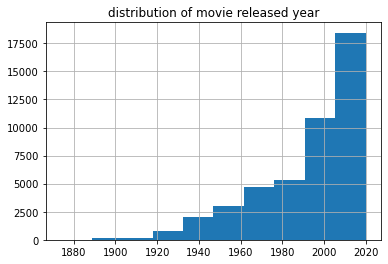

In [63]:
# plot the distribution of movie release date among different year
movies_metadata['year'].hist()
plt.title('distribution of movie released year')
plt.show()

In [64]:
# correct movie id as integer type
movies_metadata = movies_metadata[~movies_metadata['id'].str.contains('-')]

In [65]:
movies_metadata['id'] = movies_metadata['id'].astype(int)

In [66]:
movies_metadata['popularity'] = movies_metadata['popularity'].astype(float)

#### 1.3 check missing values

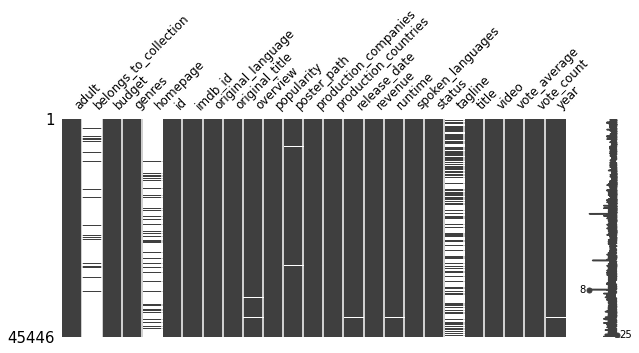

In [15]:
import missingno as msno
msno.matrix(movies_metadata,figsize=(10,4),fontsize=12)
plt.show()

base on the above missing value plot, we found `belongs_to_collection`, `homepage`, `tagline` columns have large portion of missing data, thus may not be useful

#### 1.4 making the movie item profile  
columns we think are useful for making the movie item profile include:   
1) metadata file: `id` which is the MovieID column,`adult`,`original_language`,`popularity`,`genres`,`title`,`vote_average`,`vote_count`.   
2) credict file: `cast` and `crew`

In [67]:
from ast import literal_eval
cols = ['id','adult', 'popularity','genres','title','vote_average','vote_count']
movie_profile = movies_metadata.loc[:,cols].copy()

In [68]:
movie_profile['adult'].unique()

array(['False', 'True'], dtype=object)

In [69]:
def convert(re):
    if re=='False':
        return 0
    elif re=='True':
        return 1
    
movie_profile['adult'] = movie_profile['adult'].apply(convert)

A) merge the *movies_metadata* with *credict* dataset 

In [70]:
combined = pd.merge(movie_profile, credit,left_on=movie_profile.id, right_on=credit.id)

In [71]:
combined.head(2)

,key_0,id_x,adult,popularity,genres,title,vote_average,vote_count,cast,crew,id_y
0,862,862,0,21.946943,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,8844,8844,0,17.015539,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844


In [72]:
combined.drop(columns=['id_y','key_0'],inplace=True)
combined.rename(columns={'id_x':'MovieID'},inplace=True)
combined = combined.set_index('MovieID')

B) the columns `genres, cast, crew` are present in the form of "stringified" lists , we need to convert it into python object

In [73]:
features = ['genres','cast','crew']
for feature in features:
    combined[feature] = combined[feature].apply(literal_eval)

In [74]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
        else:
            return np.nan
        
# Returns the top 3 element is the cast list
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names
    return []

In [75]:
combined['director'] = combined['crew'].apply(get_director)
features = ['cast', 'genres']
for feature in features:
    combined[feature] = combined[feature].apply(get_list)

In [76]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [77]:
# Apply clean_data function to your features.
features = ['cast','director', 'genres']
for feature in features:
    combined[feature] = combined[feature].apply(clean_data)

In [78]:
# concatenate the columns contain words (prepare the data for vectorization to make shingles)
def create_info(x):
    return ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

combined['info'] = combined.apply(create_info, axis=1)

In [79]:
combined.head(2)

,adult,popularity,genres,title,vote_average,vote_count,cast,crew,director,info
MovieID,,,,,,,,,,
862,0,21.946943,"[animation, comedy, family]",Toy Story,7.7,5415.0,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",johnlasseter,tomhanks timallen donrickles johnlasseter anim...
8844,0,17.015539,"[adventure, fantasy, family]",Jumanji,6.9,2413.0,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",,robinwilliams jonathanhyde kirstendunst adven...


In [80]:
combined['info'].isna().sum()

0

In [81]:
combined.drop(columns=['genres','cast','crew','director'],inplace=True)

In [82]:
combined.to_csv('data/combined_info.csv')